In [1]:
main_dir = 'project_folder/'
func_dir = main_dir + 'utils/'

import sys
sys.path.insert(0,func_dir)

## functions

### analysis functions

In [3]:
all_frames_reduced = {'SNR': 5, 'SNR_spont': 5, 'RS': 20, 
                      'RS_open':20, 'RS_closed': 20, 
                      'RF_thin':25, 'RF_large':25, 'RF_thin_spont':25, 'RF_large_spont':25}
all_ini_stim_offs = {'SNR': 400, 'SNR_spont': 200, 'RS': None,
                      'RS_open':None, 'RS_closed': None, 
                      'RF_thin':1000, 'RF_large':1000, 'RF_thin_spont':200, 'RF_large_spont':200}

In [2]:
import numpy as np
from ridge_regression_functions import get_best_alpha_evars

## control prediction performance by duraction of activity recording and number of predictor neurons 
    
def get_control_evars_seed(input_resp, pred_resp, input_control_lengths, pred_control_lengths, seed=17, 
                           shuffle_frames=False, condition_type_='SNR', n_splits=10, alphas = [1e4,5e5,1e5,5e5,1e6,5e6,1e7]):
    """
    Calculate prediction performance while controlling for the number of predictor neurons and trial lengths.

    Parameters:
        input_resp (ndarray): Input responses data.
        pred_resp (ndarray): Predicted responses data.
        input_control_lengths (int): Number of predictor neurons to be used for input responses.
        pred_control_lengths (int): Number of predictor neurons to be used for predicted responses.
        seed (int, optional): Seed for random number generator. Default is 17.
        shuffle_frames (bool, optional): Whether to shuffle frames. Default is False.
        condition_type_ (str, optional): Type of condition. Default is 'SNR'.
        n_splits (int, optional): Number of splits for cross-validation. Default is 10.
        alphas (list, optional): List of alpha values for ridge regression. Default is [1e4,5e5,1e5,5e5,1e6,5e6,1e7].

    Returns:
        tuple: Tuple containing prediction performance for input and predicted responses.
    """
    # Randomly select neurons based on control lengths
    if pred_resp.shape[1]>pred_control_lengths:
        np.random.seed(seed)
        pred_chosen_neurons = np.random.choice(np.arange(pred_resp.shape[1]), pred_control_lengths, replace=False)
        pred_resp_used = pred_resp[:,pred_chosen_neurons]
    else:
        pred_resp_used = pred_resp
    
    if input_resp.shape[1]> input_control_lengths:
        np.random.seed(seed)
        input_chosen_neurons = np.random.choice(np.arange(input_resp.shape[1]), input_control_lengths, replace=False)
        input_resp_used = input_resp[:,input_chosen_neurons]
    else:
        input_resp_used=input_resp
    # Calculate prediction performance for input and predicted responses
    _, evars = get_best_alpha_evars(input_resp_used, 
                                            pred_resp_used, n_splits=n_splits, alphas=alphas, 
                                            frames_reduced=all_frames_reduced[condition_type_], control_shuffle=shuffle_frames)

    _, evars2 = get_best_alpha_evars(pred_resp_used, 
                                            input_resp_used, n_splits=n_splits, alphas=alphas, 
                                            frames_reduced=all_frames_reduced[condition_type_],control_shuffle=shuffle_frames)

    return evars, evars2


from macaque_data_functions import get_resps, get_get_condition_type
import mouse_data_functions as cs
from joblib import Parallel, delayed

def get_control_evars(animal_stats,input_control_lengths, pred_control_lengths, control_trial_length,  animal='mouse', area='L23',area2='L4',
                             dataset_types = ['SNR', 'RF_thin', 'RF_large'],num_seeds=2, w_size=25, shuffle_frames=False, seed=17, n_splits=10, alphas=[1e4,5e5,1e5,5e5,1e6,5e6,1e7]):
    """
    Calculate prediction performance while controlling for trial length, number of predictor neurons, and number of trials.

    Parameters:
        animal_stats (dict): Dictionary containing animal statistics.
        input_control_lengths (int): Number of predictor neurons for input responses.
        pred_control_lengths (int): Number of predictor neurons for predicted responses.
        control_trial_length (int): Length of control trials.
        animal (str, optional): Type of animal. Default is 'mouse'.
        area (str, optional): Area for input responses. Default is 'L23'.
        area2 (str, optional): Area for predicted responses. Default is 'L4'.
        dataset_types (list, optional): Types of dataset. Default is ['SNR', 'RF_thin', 'RF_large'].
        num_seeds (int, optional): Number of seeds. Default is 2.
        w_size (int, optional): Window size. Default is 25.
        shuffle_frames (bool, optional): Whether to shuffle frames. Default is False.
        seed (int, optional): Seed for random number generator. Default is 17.
        n_splits (int, optional): Number of splits for cross-validation. Default is 10.
        alphas (list, optional): List of alpha values for ridge regression. Default is [1e4,5e5,1e5,5e5,1e6,5e6,1e7].

    Returns:
        None
    """
    # Iterate through dataset types
    for condition_type in dataset_types:
        if animal=='mouse':
            mt = cs.mt_retriever(main_dir, dataset_type=condition_type)
        for mouse_or_date in animal_stats[condition_type]:
            all_evars, all_evars2 = [],[]
            if animal=='mouse':
                resp_L1, pred_resp, resp_L2, resp_L3, input_resp = mt.retrieve_layer_activity('resp', mouse_or_date)
                if len(resp_L1)<1000:
                    continue
            else:
                get_condition_type = get_get_condition_type(condition_type)
                pred_resp, input_resp= get_resps(condition_type=get_condition_type, date=mouse_or_date, w_size=w_size, stim_on=0, stim_off=all_ini_stim_offs[condition_type])
            if pred_resp.shape[0]> control_trial_length:
                # get random frame index to subsample from. have to chose a number that is less than n_frames-control trial length
                # in case it's towards the end.
                control_first_indices = [np.random.choice(np.arange(pred_resp.shape[0]-control_trial_length)) for _ in range(num_seeds)]
                results = Parallel(n_jobs=-1)(delayed(get_control_evars_seed)(input_resp=input_resp[i:i+control_trial_length,:], 
                                                                            pred_resp=pred_resp[i:i+control_trial_length,:], 
                                                                            input_control_lengths = input_control_lengths,
                                                                            pred_control_lengths=pred_control_lengths,
                                                                            shuffle_frames=shuffle_frames, seed=seed,
                                                                            condition_type_=condition_type, n_splits=n_splits) for i in control_first_indices)
                for evar, evar2 in results:
                    all_evars.append(evar)
                    all_evars2.append(evar2)
                evars = np.mean(np.array(all_evars), axis=0)
                evars2=np.mean(np.array(all_evars2), axis=0)
            else:
                evars, evars2 = get_control_evars_seed(input_resp=input_resp, pred_resp=pred_resp,
                                                       input_control_lengths = input_control_lengths,
                                                        pred_control_lengths=pred_control_lengths,
                                                        shuffle_frames=shuffle_frames, seed=seed,
                                                            condition_type_=condition_type)

            if shuffle_frames is True:
                animal_stats[condition_type][mouse_or_date][area]['stimulus_type_evars_null']=evars
                animal_stats[condition_type][mouse_or_date][area2]['stimulus_type_evars_null']=evars2
            else:
                animal_stats[condition_type][mouse_or_date][area]['stimulus_type_evars']=evars
                animal_stats[condition_type][mouse_or_date][area2]['stimulus_type_evars']=evars2
        print(f'{condition_type} done')

### plotting functions

In [8]:
import pandas as pd
def extract_mouse_name(input_string):
    index_of_MP = input_string.find('MP')
    return input_string[index_of_MP:index_of_MP + 5] if index_of_MP != -1 and index_of_MP + 5 <= len(input_string) else None
def get_property_dataset_type(input_string):
    if 'spont' in input_string:
        return input_string.replace('_spont','')
    else:
        return input_string 
def make_mouse_df_stimulus_comparisons(mouse_stats_, dataset_types=['ori32','natimg32']):
    data = []
    for dataset_type in dataset_types:
        if 'spont' in dataset_type:
            act_type = 'gray screen'
        else:
            act_type = 'stimulus'
        for mouse, areas_data in mouse_stats_[dataset_type].items():
            mouse_name = extract_mouse_name(mouse)
            for area, values in areas_data.items():
                if area=='L23':
                    direction = 'L4→L2/3'
                    area_ = 'L2/3'
                else:
                    direction = 'L2/3→L4'
                    area_=area
                split_half_rs = mouse_stats[get_property_dataset_type(dataset_type)][mouse][area]['split_half_r']
                SNRs = mouse_stats[get_property_dataset_type(dataset_type)][mouse][area]['SNR_meanspont']
                for split_half_r, snr,max_corr_val, evar, null_evar in zip(split_half_rs, SNRs,values['max_corr_val'],values['stimulus_type_evars'],values['stimulus_type_evars_null']):
                    data.append({
                        'Dataset Type': dataset_type,
                        'Activity Type': act_type,
                        'Mouse': mouse,
                        'Mouse_Name':mouse_name,
                        'Area': area_,
                        'Direction':direction,
                        'EV': evar,
                        'SNR': snr,
                        'Split-half r': split_half_r,
                        'max corr. val':max_corr_val,
                        'control_shuffle':False, 
                    })
                    data.append({
                        'Dataset Type': dataset_type,
                        'Activity Type': act_type,
                        'Mouse': mouse,
                        'Mouse_Name':mouse_name,
                        'Area': area_,
                        'Direction':direction,
                        'EV': null_evar,
                        'SNR': snr,
                        'Split-half r': split_half_r,
                        'max corr. val':max_corr_val,
                        'control_shuffle':True, 
                    })
    # Create a DataFrame from the flattened data
    df_mouse_all = pd.DataFrame(data)
    return df_mouse_all

def get_property_dataset_type_monkey(input_string):
    if 'spont' in input_string:
        return input_string.replace('_spont','')
    elif 'RS' in input_string:
        return 'SNR'
    else:
        return input_string 

def make_monkey_df_stimulus_comparisons(monkey_stats_, dataset_types=['SNR', 'RF_thin', 'RF_large']):
    data = []
    for dataset_type in dataset_types:
        if 'spont' in dataset_type:
            act_type = 'gray screen'
        elif 'RS' in dataset_type:
            act_type = 'lights off'
        else:
            act_type = 'stimulus'
        for date, areas_data in monkey_stats_[dataset_type].items():
            for area, values in areas_data.items():
                if area=='V4':
                    direction = 'V1→V4'
                else:
                    direction = 'V4→V1'
                split_half_rs = monkey_stats_[get_property_dataset_type_monkey(dataset_type)][date][area]['split_half_r']
                SNRs = monkey_stats_[get_property_dataset_type_monkey(dataset_type)][date][area]['SNR_meanspont']
                for split_half_r, snr,max_corr_val, evar, null_evar in zip(split_half_rs, SNRs,values['max_corr_val'],values['stimulus_type_evars'],values['stimulus_type_evars_null']):
                    data.append({
                        'Dataset Type': dataset_type,
                        'Activity Type': act_type,
                        'Date':date,
                        'Area': area,
                        'Direction':direction,
                        'EV': evar,
                        'SNR': snr,
                        'max corr. val':max_corr_val,
                        'Split-half r': split_half_r,
                        'control_shuffle':False, 
                    })
                    data.append({
                        'Dataset Type': dataset_type,
                        'Activity Type': act_type,
                        'Date': date,
                        'Area': area,
                        'Direction':direction,
                        'EV': null_evar,
                        'SNR': snr,
                        'max corr. val':max_corr_val,
                        'Split-half r': split_half_r,
                        'control_shuffle':True, 
                    })
    # Create a DataFrame from the flattened data
    df_monkey_all = pd.DataFrame(data)
    return df_monkey_all

In [9]:

def plot_comparisons(x, y, data, ax, palette=None, hue=None, order=None, hue_order=None, bar_plot=False):
    if bar_plot is True:
        sns.barplot(x=str(x), y=y,data=data, hue=hue, 
                ax=ax,
                errorbar='se', hue_order=hue_order, order=order,
                palette=palette, errcolor = "black")
    else:
        sns.boxplot(data=data, x=str(x), y=y, hue=hue, ax=ax, showfliers=False,
                    palette=palette, hue_order=hue_order, order=order,
                    )
    sns.despine()
    ax.set(xlabel=None,
        ylabel=None,
        xticklabels='',
        )
    ax.set_xticks([])
    # Set the fontsize of y-axis tick labels
    ax.yaxis.set_tick_params(labelsize=17)
    ax.legend(loc=(1.1,0.5))

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns


def fig4_violinplot(df, x, y, hue, ax,label_order, hue_order, **args):
    sns.violinplot(x=x, y=y, hue=hue, 
                data=df,ax=ax,order=label_order, hue_order=hue_order,
                inner='box',
                inner_kws={'box_width':2, 'whis_width':0.5,
                            'marker':'_', 'markersize':3,
                            'markeredgewidth':0.8,
                            },
                            **args
                            )
    ax.set(xlabel=None
        )

from matplotlib import collections
def add_violin_custom_colors(ax):
    
    custom_colors = ['#72BEB7','#B6E3DF','#EDAEAE','#f6d6d6']
    #custom_colors = ['lightseagreen','#B6E3DF','lightcoral', '#F1C0C0']
    violins  = [s for s in ax.get_children() if isinstance(s, collections.PolyCollection)]
    for violin, color in zip(violins, custom_colors):
        violin.set_facecolor(color)


from stats_functions import get_t_test_stars
def add_stars_2_sets(df_, neuron_property, x, x_order, hue, ax, fontsize=7, height1=0.97, height2=0.97, perm_t=True, perm_type='ind', hierarchical=False, mouse_or_date='Mouse_Name'):
    stars1 = get_t_test_stars(df_[df_[x]==x_order[0]], hue, neuron_property, perm_t=perm_t, perm_type=perm_type, hierarchical=hierarchical, mouse_or_date=mouse_or_date)
    stars2 = get_t_test_stars(df_[df_[x]==x_order[1]], hue, neuron_property, perm_t=perm_t, perm_type=perm_type,hierarchical=hierarchical, mouse_or_date=mouse_or_date)
    if stars1 == 'n.s.':
        height1 = height1 + 0.02
        fontsize1 = fontsize*0.9
        color1='#C0C0C0'
    else:
        fontsize1 = fontsize
        color1='black'
        
    if stars2 == 'n.s.':
        height2 = height2 + 0.02
        fontsize2 = fontsize*0.9
        color2='#C0C0C0'
    else:
        fontsize2 = fontsize
        color2='black'
    
    ax.text(0.25, height1, stars1, ha='center', va='center', fontsize=fontsize1, transform=ax.transAxes, color=color1)
    ax.text(0.75, height2, stars2, ha='center', va='center', fontsize=fontsize2, transform=ax.transAxes, color=color2)

def plot_null_line(df_, neuron_property, ax, linestyle='--', color='blue', label='95% CI\ncontrol'):
    
    confidence_interval = stats.t.interval(0.95, len(df_[neuron_property]) - 1, loc=df_[neuron_property].mean(), scale=stats.sem(df_[neuron_property]))
    ax.axhspan(confidence_interval[0], confidence_interval[1], alpha=0.1, color=color, label=label,
        linestyle=linestyle,
        )
    
from matplotlib import collections
def add_violin_custom_colors_3(ax):
    custom_colors = ['#136a66','#72BEB7','#B6E3DF','#a85959','#EDAEAE', '#f6d6d6']
    violins  = [s for s in ax.get_children() if isinstance(s, collections.PolyCollection)]
    for violin, color in zip(violins, custom_colors):
        violin.set_facecolor(color)

from stats_functions import get_oneway_anova_stars
def add_anova_stars_2_sets(df_, neuron_property, x, x_order, hue, hue_order, ax, fontsize=7, height1=0.95, height2=1.02,height3=0.95, 
stars1_positions=None, stars2_positions=None, bar_height=0.02, perm_t=True, perm_type='ind'):
    
    star1_labels,all_stars1 = get_oneway_anova_stars(df_[df_[x]==x_order[0]], hue, hue_order, neuron_property, perm_t=perm_t, perm_type=perm_type)
    star2_labels, all_stars2 = get_oneway_anova_stars(df_[df_[x]==x_order[1]], hue, hue_order, neuron_property, perm_t=perm_t, perm_type=perm_type)
    height_positions = [height1,height2, height3]
    if stars1_positions is None:
        stars1_positions= [0.17,0.25,0.33]
    if stars2_positions is None:
        stars2_positions= [0.67,0.76,0.86]
    bar_halflength = 0.12

    
    for s, (star1, star2) in enumerate(zip(all_stars1, all_stars2)):
        if star1 =='n.s.':
            height1 = height_positions[s] + 0.018
            fontsize1 = fontsize*0.9
            color1='#C0C0C0'
        else:
            height1 = height_positions[s]
            fontsize1=fontsize
            color1='black'
        if star2 =='n.s.':
            height2 = height_positions[s] + 0.018
            fontsize2 = fontsize*0.9
            color2='#C0C0C0'
        else:
            height2 = height_positions[s]
            fontsize2 = fontsize
            color2='black'

        ax.text(stars1_positions[s], height1, star1, ha='center', va='center', fontsize=fontsize1, transform=ax.transAxes, color=color1)
        ax.text(stars2_positions[s], height2, star2, ha='center', va='center', fontsize=fontsize2, transform=ax.transAxes, color=color2)
        if s==1:
            if star1 is not None:
                ax.hlines(height_positions[s]- bar_height, stars1_positions[s] - bar_halflength, stars1_positions[s] + bar_halflength, 
                        color=color1,transform=ax.transAxes, linewidth=0.5)
            if star2 is not None:
                ax.hlines(height_positions[s]- bar_height, stars2_positions[s] - bar_halflength, stars2_positions[s] + bar_halflength, 
                        color=color2,transform=ax.transAxes, linewidth=0.5)

### supplemental plotting functions

In [11]:
import seaborn as sns
def plot_neuronal_properties_comparison(df_, variable1, neuron_property, variable2, 
                                        ax, fontsize=7, label_order=None, hue_order=None, 
                                        yticks=None, ylabel=None,animal='mouse', stats_args=None, 
                                        mouse_height1=0.97,mouse_height2=0.97,
                                        **plot_args):
    
    if animal == 'mouse':
        palette = ['#72BEB7','#B6E3DF']
    else:
        palette = ['#72BEB7','#B6E3DF','lightgray']
    fig4_violinplot(df_, x=variable1, y=neuron_property, 
                hue=variable2, ax=ax, label_order=label_order,
                hue_order=hue_order, saturation=1,
                gap=-0.5,width=0.75, linewidth=0, 
                alpha=0.7,palette=palette,cut=0,
                **plot_args)
    ax.legend_.remove()
    sns.despine()
    
    if animal == 'mouse':
        add_violin_custom_colors(ax)
        add_stars_2_sets(df_, neuron_property, x=variable1, x_order=label_order,
                         hue=variable2, ax=ax, hierarchical=True, **stats_args)
    else:
        add_violin_custom_colors_3(ax)
        add_anova_stars_2_sets(df_, neuron_property, x=variable1, x_order=label_order, hue=variable2, 
                               hue_order=hue_order, ax=ax, **stats_args)
    ax.tick_params(axis='both', labelsize=fontsize, width=0.3, length=2, pad=1)
    ax.spines[:].set_linewidth(0.3)
    if yticks is not None:
        ax.set_yticks(ticks=yticks)
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=fontsize, labelpad=1)
    else:
        ax.set_ylabel(neuron_property, fontsize=fontsize, labelpad=1)


## Mouse dataset type comparisons

In [17]:
## store the lengths of the neurons and frames
from neuron_properties_functions import create_empty_mouse_stats_dict, get_split_half_r_all_mice, get_SNR_all_mice, get_max_corr_vals_all_mice
mouse_stats= create_empty_mouse_stats_dict(main_dir)
get_SNR_all_mice(main_dir, mouse_stats)
get_split_half_r_all_mice(main_dir, mouse_stats)
get_max_corr_vals_all_mice(main_dir, mouse_stats)

import mouse_data_functions as cs
seed = 17
dataset_types = ['ori32','natimg32']
area='L23'
area2='L4'
activity_type = 'resp'
L23_lengths = []
L4_lengths = []
trial_lengths = []
for dataset_type in dataset_types:
    mt = cs.mt_retriever(main_dir, dataset_type=dataset_type)
    mousenames= sorted(mt.filenames)
    for mouse in mousenames:
        resp_L1, resp_L23, resp_L2, resp_L3, resp_L4 = mt.retrieve_layer_activity(activity_type, mouse)
        L23_lengths.append(len(mouse_stats[dataset_type][mouse]['L23']['SNR_meanspont']))
        L4_lengths.append(len(mouse_stats[dataset_type][mouse]['L4']['SNR_meanspont']))
        trial_lengths.append(resp_L23.shape[0])

L23_control_lengths = L23_lengths[np.argsort(np.array(L23_lengths))[1]]
L4_control_lengths = L4_lengths[np.argsort(np.array(L4_lengths))[1]]
control_trial_length = np.min(trial_lengths)

In [ ]:
import time
start_time = time.time()
get_control_evars(mouse_stats,input_control_lengths=L4_control_lengths,pred_control_lengths= L23_control_lengths,
                  control_trial_length=control_trial_length,animal='mouse', area=area,area2=area2,dataset_types=dataset_types,
                  num_seeds=10, shuffle_frames=False, seed=20)
end_time = time.time()
elapsed_time = (end_time - start_time)/60
print(f'Yay! all done. Took {elapsed_time:.4f} minutes to complete') 

In [ ]:
## shuffle control
import time
start_time = time.time()
get_control_evars(mouse_stats,input_control_lengths=L4_control_lengths,pred_control_lengths= L23_control_lengths,
                  control_trial_length=control_trial_length,animal='mouse', area=area,area2=area2,dataset_types=dataset_types,
                  num_seeds=10, shuffle_frames=True, seed=20)
end_time = time.time()
elapsed_time = (end_time - start_time)/60
print(f'Yay! all done. Took {elapsed_time:.4f} minutes to complete') 

### plotting

In [12]:
df_mouse_all = make_mouse_df_stimulus_comparisons(mouse_stats)
dfmouse = df_mouse_all[df_mouse_all.control_shuffle==False].reset_index()

variable1='Direction'
variable2='Dataset Type'
filt_df_mouse = dfmouse[(dfmouse.SNR>2)&(dfmouse['Split-half r']>0.8)]
filt_df_mouse = filt_df_mouse[filt_df_mouse['Mouse_Name'].isin(['MP031','MP032','MP033'])].reset_index()
filt_df_mouse_null = df_mouse_all[(df_mouse_all.SNR>2)&(df_mouse_all['Split-half r']>0.8)&(df_mouse_all.control_shuffle==True)]
filt_df_mouse_null = filt_df_mouse_null[filt_df_mouse_null['Mouse_Name'].isin(['MP031','MP032','MP033'])].reset_index()
dataset_types = ['ori32', 'natimg32']
directions= ['L4→L2/3', 'L2/3→L4']
palette= ['#D3D3D3','#404040']

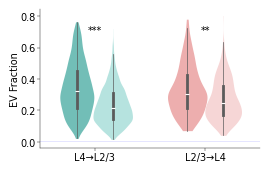

In [13]:
neuron_property='EV'
fig, ax = plt.subplots(figsize=((2.85,1.8)))
fontsize=7
fig4_violinplot(filt_df_mouse, x=variable1, y=neuron_property, 
                hue=variable2, ax=ax,
                label_order=directions, hue_order=dataset_types,
                gap=-0.1,width=0.65,cut=0,
                linewidth=0, saturation=1, palette=['#72BEB7','#EDAEAE']
                )

ax.legend_.remove()
ax.tick_params(axis='both', labelsize=fontsize, width=0.3, length=2, pad=1)
add_violin_custom_colors(ax)
sns.despine()
ax.spines[:].set_linewidth(0.3)
ax.set_ylabel('EV Fraction', fontsize=fontsize, labelpad=0)

add_stars_2_sets(filt_df_mouse, neuron_property, x=variable1, x_order=directions,
                 hue=variable2, ax=ax, height1=0.85, height2=0.85, perm_type='ind', hierarchical=True)

data = filt_df_mouse_null['EV']
per_25 = np.percentile(data.dropna().values, 25)
per_75 = np.percentile(data.dropna().values, 75)
ax.axhspan(per_25, per_75, alpha=0.1, color='blue', label='shuffle\ncontrol IQR',
        linewidth=0,
           )
plt.show()

### supplemental

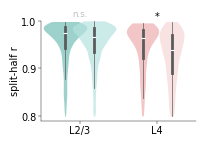

In [14]:
import matplotlib.pyplot as plt
variable1='Area'
variable2='Dataset Type'
dataset_types = ['ori32', 'natimg32']
directions= ['L2/3','L4']
figsize=(2,1.3)

mouse_args = {'height1':1.05, 'height2':1.05}

neuron_property='Split-half r'
fig, ax = plt.subplots(figsize=figsize)
plot_neuronal_properties_comparison(filt_df_mouse, variable1, neuron_property, variable2, 
                                        ax, fontsize=7, label_order=directions, hue_order=dataset_types, 
                                        yticks=[0.8,0.9,1], ylabel='split-half r', animal='mouse', stats_args=mouse_args)
# Get the y-axis ticks
y_ticks = plt.gca().get_yticks()
# Check if 1 is among the ticks
if 1 in y_ticks:
    ax.set_ylim(top=1)
    
plt.show()

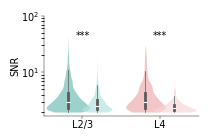

In [39]:
neuron_property='SNR'
fig, ax = plt.subplots(figsize=figsize)
plot_neuronal_properties_comparison(filt_df_mouse, variable1, neuron_property, variable2, 
                                        ax, fontsize=7, label_order=directions, hue_order=dataset_types,
                                        ylabel=None, log_scale=True, stats_args={'height1':0.8, 'height2':0.8})
ax.set_ylim(top=100)
plt.show()

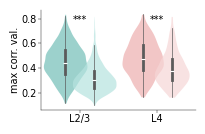

In [40]:
neuron_property='max corr. val'
fig, ax = plt.subplots(figsize=figsize)
plot_neuronal_properties_comparison(filt_df_mouse, variable1, neuron_property, variable2, 
                                        ax, fontsize=7, label_order=directions, hue_order=dataset_types, 
                                        yticks=None, ylabel='max corr. val.', animal='mouse',stats_args={'height1':0.9, 'height2':0.9})
plt.show()

## Monkey dataset type comparisons

In [30]:
from neuron_properties_functions import create_empty_monkey_stats_dict, get_SNR_monkey_all_dates, get_split_half_r_monkey_all_dates, get_max_corr_vals_monkey_all_dates

monkey_stats= create_empty_monkey_stats_dict()
get_SNR_monkey_all_dates(monkey_stats)
get_split_half_r_monkey_all_dates(monkey_stats)
get_max_corr_vals_monkey_all_dates(monkey_stats)

V4_lengths = []
V1_lengths = []
area='V4'
area2='V1'
dataset_types = ['SNR', 'RF_thin', 'RF_large']
w_size=25
for dataset_type in dataset_types:
    for date in monkey_stats[dataset_type]:
        V4_lengths.append(len(monkey_stats[dataset_type][date][area]['evars']))
        V1_lengths.append(len(monkey_stats[dataset_type][date][area2]['evars']))
        resp_V4, resp_V1= get_resps(condition_type=get_get_condition_type(dataset_type), date=date, w_size=w_size, stim_on=0, stim_off=stim_offs[dataset_type])
        trial_lengths.append(resp_V4.shape[0])

alphas = [1e4,1e5,5e5,1e6,5e6,1e7]
V4_control_lengths = V4_lengths[np.argsort(np.array(V4_lengths))[1]] #control for number of neurons?
V1_control_lengths = V1_lengths[np.argsort(np.array(V1_lengths))[1]]
control_trial_length = np.min(trial_lengths)

In [ ]:
import time
start_time = time.time()
get_control_evars(monkey_stats,input_control_lengths=V1_control_lengths,pred_control_lengths= V4_control_lengths,
                  control_trial_length=control_trial_length,animal='monkey', area=area,area2=area2,dataset_types=dataset_types,
                  num_seeds=10, shuffle_frames=False, seed=20)
end_time = time.time()
elapsed_time = (end_time - start_time)/60
print(f'Yay! all done. Took {elapsed_time:.4f} minutes to complete') 

In [ ]:
### shuffle control
import time
start_time = time.time()
get_control_evars(monkey_stats,input_control_lengths=V1_control_lengths,pred_control_lengths= V4_control_lengths,
                  control_trial_length=control_trial_length,animal='monkey', area=area,area2=area2,dataset_types=dataset_types,
                  num_seeds=10, shuffle_frames=True, seed=20)
end_time = time.time()
elapsed_time = (end_time - start_time)/60
print(f'Yay! all done. Took {elapsed_time:.4f} minutes to complete')

### plotting

In [15]:
df_monkey_all = make_monkey_df_stimulus_comparisons(monkey_stats)
filt_df_monkey = df_monkey_all[(df_monkey_all.control_shuffle==False)&(df_monkey_all['Split-half r']>0.8)&(df_monkey_all.SNR>=2)].reset_index()
filt_df_monkey_null= df_monkey_all[(df_monkey_all.control_shuffle==True)&(df_monkey_all['Split-half r']>0.8)&(df_monkey_all.SNR>=2)].reset_index()
dataset_types=['RF_thin', 'RF_large', 'SNR']
variable1='Direction'
variable2='Dataset Type'
directions = ['V1→V4','V4→V1']
figsize=(3,2)


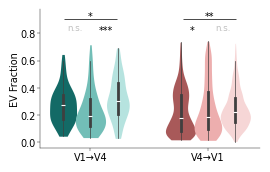

In [16]:
neuron_property='EV'
fig, ax = plt.subplots(figsize=((2.85,1.8)))
fontsize=7
fig4_violinplot(filt_df_monkey, x=variable1, y=neuron_property, 
                hue=variable2, ax=ax, label_order=directions, 
                hue_order=dataset_types, gap=-0.1,width=0.7,cut=0,
                linewidth=0, saturation=1, palette=['lightseagreen','lightcoral','#72BEB7']
                )
ax.legend_.remove()
sns.despine()
ax.set_ylabel('EV Fraction', fontsize=fontsize, labelpad=0)
ax.tick_params(axis='both', labelsize=fontsize, width=0.3, length=2, pad=1)
sns.despine()
ax.spines[:].set_linewidth(0.3)
add_violin_custom_colors_3(ax)
add_anova_stars_2_sets(filt_df_monkey, neuron_property, x=variable1, x_order=directions,
                       hue=variable2, hue_order=dataset_types, ax=ax, fontsize=fontsize,height1=0.85, height2=0.95, height3=0.85,
                       stars1_positions=[0.16,0.23,0.30],
                       stars2_positions=[0.69,0.77,0.83],
                       )
data = filt_df_monkey_null['EV']
per_25 = np.percentile(data.dropna().values, 25)
per_75 = np.percentile(data.dropna().values, 75)
ax.axhspan(per_25, per_75, alpha=0.1, color='blue', label='shuffle\ncontrol IQR',
        linewidth=0,
           )
# Get the y-axis ticks
y_ticks = plt.gca().get_yticks()
# Check if 1 is among the ticks
if 1 in y_ticks:
    ax.set_ylim(top=1)
plt.show()



### supplemental

In [17]:
variable1='Area'
variable2='Dataset Type'
dataset_types = ['RF_thin', 'RF_large', 'SNR']
directions= ['V4','V1']
figsize=(2,1.3)


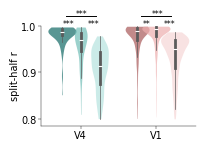

In [18]:
stats_args = {'fontsize': fontsize*0.8, 'height1':1.02, 'height2': 1.12, 'height3': 1.02, 'stars1_positions': [0.18,0.26,0.34],'stars2_positions':[0.68,0.75,0.83],'bar_height':0.02 }
neuron_property='Split-half r'

fig, ax = plt.subplots(figsize=figsize)
plot_neuronal_properties_comparison(filt_df_monkey, variable1, neuron_property, variable2, 
                                        ax, fontsize=7, label_order=directions, hue_order=dataset_types, 
                                        yticks=[0.8,0.9,1], ylabel='split-half r', animal='monkey', stats_args=stats_args)
# Get the y-axis ticks
y_ticks = plt.gca().get_yticks()
# Check if 1 is among the ticks
if 1 in y_ticks:
        ax.set_ylim(top=1)
ax.plot([-0.2,0.2], # -0.095, units are width of the axes
        [1.101, 1.101], # 0 to 500, units are same as the y-axis
        clip_on=False,
        transform=ax.get_xaxis_transform(),
        color='black', linewidth=0.7)
ax.plot([0.804,1.2], # -0.095, units are width of the axes
        [1.101, 1.101], # 0 to 500, units are same as the y-axis
        clip_on=False,
        transform=ax.get_xaxis_transform(),
        color='black', linewidth=0.7)
plt.show()

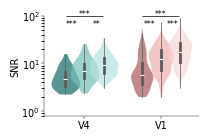

In [19]:
stats_args = {'fontsize': fontsize*0.8, 'height1':0.92, 'height2': 1.02, 'height3': 0.92, 
              'stars1_positions': [0.18,0.26,0.34],'stars2_positions':[0.68,0.75,0.83],'bar_height':0.02 }
neuron_property='SNR'
fig, ax = plt.subplots(figsize=figsize)
plot_neuronal_properties_comparison(filt_df_monkey, variable1, neuron_property, variable2, 
                                        ax, fontsize=7, label_order=directions, hue_order=dataset_types, 
                                        yticks=None, ylabel=None, animal='monkey', stats_args=stats_args,
                                        log_scale=True)
ax.set_ylim(top=100)
plt.show()

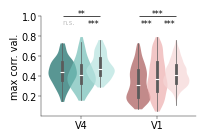

In [69]:
stats_args = {'fontsize': fontsize*0.8, 'height1':0.92, 'height2': 1.02, 'height3': 0.92,'stars1_positions': [0.18,0.26,0.34],'stars2_positions':[0.68,0.75,0.83],'bar_height':0.02 }
neuron_property='max corr. val'

fig, ax = plt.subplots(figsize=figsize)
plot_neuronal_properties_comparison(filt_df_monkey, variable1, neuron_property, variable2, 
                                        ax, fontsize=7, label_order=directions, hue_order=dataset_types, 
                                        yticks=None, ylabel='max corr. val.', animal='monkey', stats_args=stats_args)
# Get the y-axis ticks
y_ticks = plt.gca().get_yticks()
# Check if 1 is among the ticks
if 1 in y_ticks:
    ax.set_ylim(top=1)
plt.show()

In [3]:
main_dir = '/Users/diannahidalgo/Documents/thesis_shenanigans/aim2_project/inter_areal_predictability_github/'
func_dir = main_dir + 'utils/'

import sys
sys.path.insert(0,func_dir)

In [5]:


main_dir = '/Users/diannahidalgo/Documents/thesis_shenanigans/aim2_project/'

import pickle
# File path where you want to save the dictionary
file_path = main_dir + f'results/animal_stats/'

with open(file_path + 'mouse_stats_2_26_24', 'rb') as file:
    old_mouse_stats = pickle.load(file)

with open(file_path + 'monkey_stats_2_25_24', 'rb') as file:
    old_monkey_stats = pickle.load(file)


In [6]:
import copy
from neuron_properties_functions import create_empty_mouse_stats_dict

mouse_stats= create_empty_mouse_stats_dict(main_dir)

for dataset_type in ['ori32', 'natimg32']:
    for mouse, area_data in mouse_stats[dataset_type].items():
        for area, values in area_data.items():
            mouse_stats[dataset_type][mouse][area]['stimulus_type_evars']=copy.deepcopy(old_mouse_stats[dataset_type][mouse][area]['control_evars'])
            mouse_stats[dataset_type][mouse][area]['stimulus_type_evars_null']=copy.deepcopy(old_mouse_stats[dataset_type][mouse][area]['control_evars_null'])
            mouse_stats[dataset_type][mouse][area]['SNR_meanspont']=copy.deepcopy(old_mouse_stats[dataset_type][mouse][area]['SNR_meanspont'])
            mouse_stats[dataset_type][mouse][area]['max_corr_val']=copy.deepcopy(old_mouse_stats[dataset_type][mouse][area]['max_corr_vals'])
            mouse_stats[dataset_type][mouse][area]['split_half_r']=copy.deepcopy(old_mouse_stats[dataset_type][mouse][area]['traditional_reli'])


In [7]:
import copy
import numpy as np
from neuron_properties_functions import create_empty_monkey_stats_dict

monkey_stats= create_empty_monkey_stats_dict()

for dataset_type in ['SNR', 'RF_thin','RF_large']:
    for date, area_data in monkey_stats[dataset_type].items():
        for area, values in area_data.items():
            if len(old_monkey_stats[dataset_type][date][area]['control_evars'].shape) > 1:
                monkey_stats[dataset_type][date][area]['stimulus_type_evars']=np.nanmean(old_monkey_stats[dataset_type][date][area]['control_evars'], axis=0)
                monkey_stats[dataset_type][date][area]['stimulus_type_evars_null']=np.nanmean(old_monkey_stats[dataset_type][date][area]['control_evars_null'], axis=0)

            else:
                monkey_stats[dataset_type][date][area]['stimulus_type_evars']=copy.deepcopy(old_monkey_stats[dataset_type][date][area]['control_evars'])
                monkey_stats[dataset_type][date][area]['stimulus_type_evars_null']=copy.deepcopy(old_monkey_stats[dataset_type][date][area]['control_evars_null'])

            monkey_stats[dataset_type][date][area]['SNR_meanspont']=copy.deepcopy(old_monkey_stats[dataset_type][date][area]['SNR_meanspont'])
            monkey_stats[dataset_type][date][area]['max_corr_val']=copy.deepcopy(old_monkey_stats[dataset_type][date][area]['max_corr_vals'])
            monkey_stats[dataset_type][date][area]['split_half_r']=copy.deepcopy(old_monkey_stats[dataset_type][date][area]['traditional_reli'])
